In [2]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../utils_mapping.R')    
})


# Object 1: All

## Load

In [3]:
meta_data <- readRDS('/data/srlab/ik936/Roche/data/cache/cell_df_Mar30_2020.rds') %>% 
    subset(Tissue == 'Synovium') 

exprs_raw <- readRDS('/data/srlab/ik936/Roche/data/cache/exprs_raw_matrix_n79_Mar30_2020.rds')[, meta_data$CellID]


## QC

In [4]:
head(meta_data)

CellID,LibraryID,nGene,nUMI,percent_mito,SampleID,Technology,Tissue,DonorID,Case,Diagnosis,scDblFinder.weighted,scDblFinder.ratio,scDblFinder.score,scDblFinder.class
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
AAACCTGGTCAATGTC_180116A,180116A,1235,2557,0.09894408,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,1.00000000,1.00,1.00000000,doublet
AAACCTGGTGATGTGG_180116A,180116A,1772,5073,0.04356397,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.96519370,0.95,0.96519370,doublet
AAACGGGTCACGCGGT_180116A,180116A,930,3551,0.07687975,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.09969786,0.10,0.09969786,singlet
AAACGGGTCTGGTATG_180116A,180116A,1578,4704,0.02125850,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.09833071,0.10,0.09833071,singlet
AAAGATGAGTGAAGAG_180116A,180116A,529,1269,0.05516154,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.00000000,0.00,0.00000000,singlet
AAAGCAATCGTCGTTC_180116A,180116A,2460,8303,0.02541250,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.09917391,0.10,0.09917391,singlet


Picking joint bandwidth of 0.0268

Picking joint bandwidth of 0.031



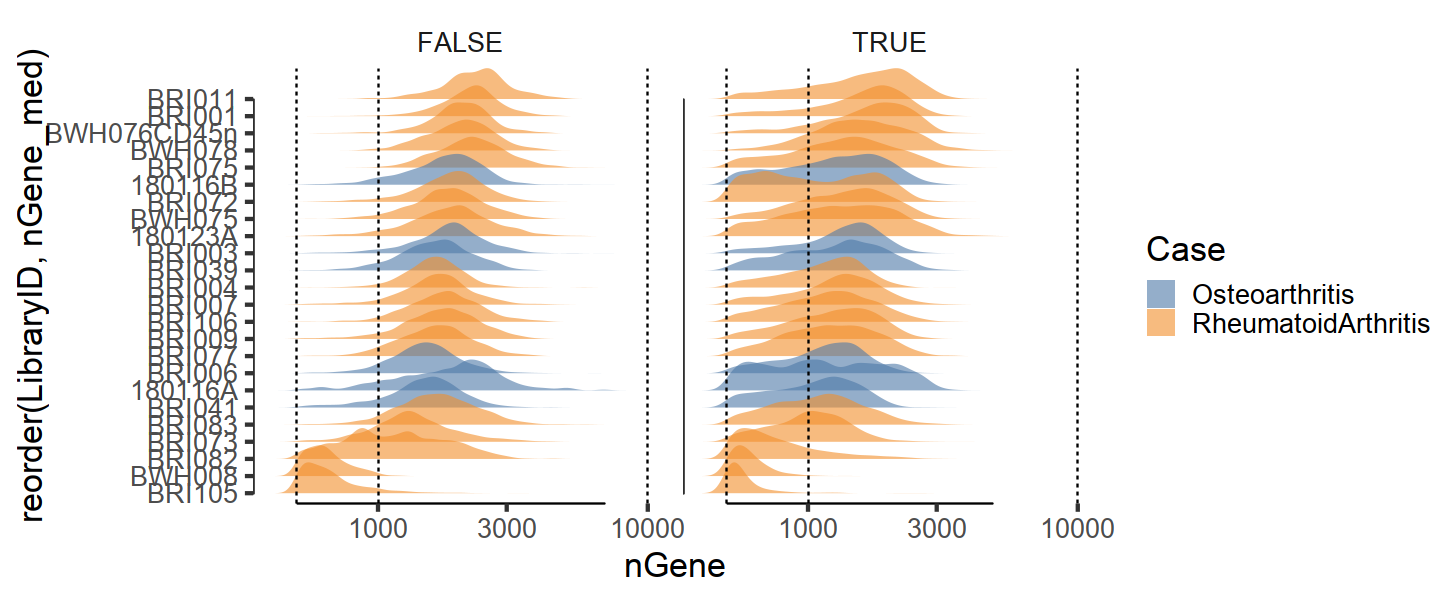

In [5]:
fig.size(5, 12)
data.table(meta_data)[
    !is.na(scDblFinder.class)
][
    , nGene_med := median(nGene), by = LibraryID
][] %>% 
    ggplot(aes(nGene, reorder(LibraryID, nGene_med), fill = Case)) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        scale_x_continuous(trans = 'log10') + 
        geom_vline(xintercept = c(500, 1e3, 1e4), linetype = 2) + 
        scale_fill_tableau() + 
        facet_wrap(~scDblFinder.score < 0.2, ncol = 2) + 
#         facet_wrap(~scDblFinder.class, ncol = 2) + 
        NULL


Picking joint bandwidth of 0.00381

Picking joint bandwidth of 0.0051



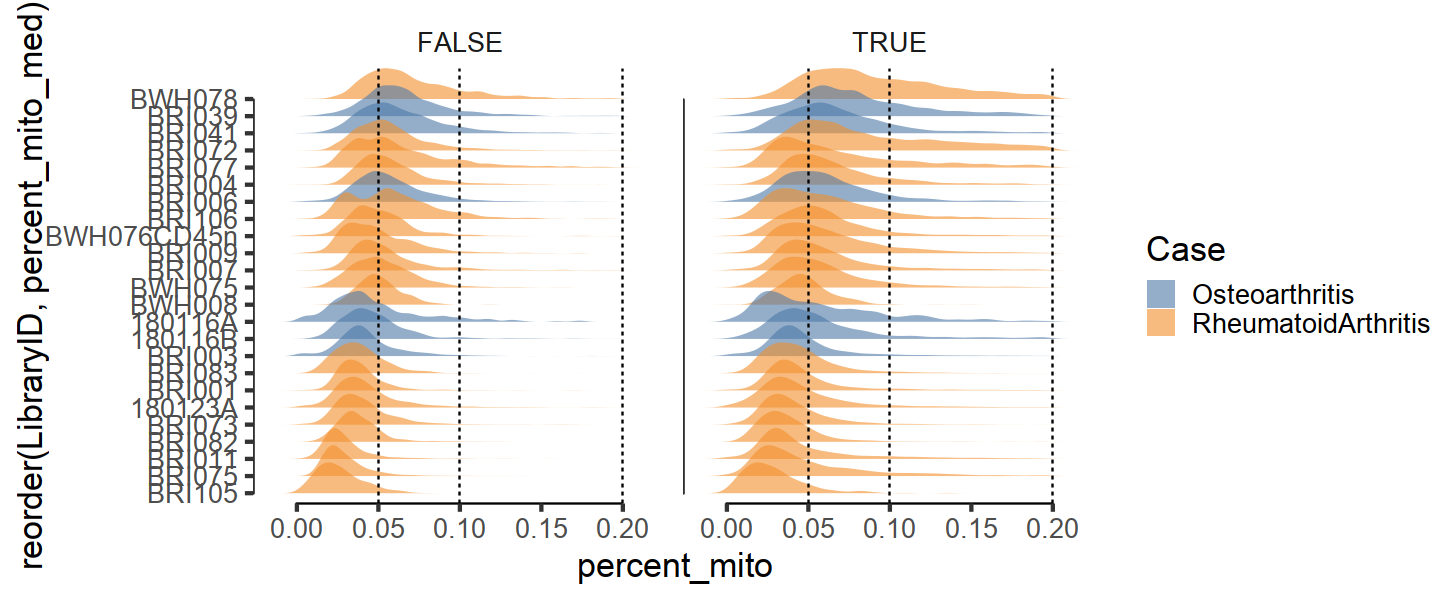

In [6]:
fig.size(5, 12)
data.table(meta_data)[
    !is.na(scDblFinder.class)
][
    , percent_mito_med := median(percent_mito), by = LibraryID
][] %>% 
    ggplot(aes(percent_mito, reorder(LibraryID, percent_mito_med), fill = Case)) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        geom_vline(xintercept = c(.05, .1, .2), linetype = 2) + 
        scale_fill_tableau() + 
        facet_wrap(~scDblFinder.score < 0.2, ncol = 2) + 
#         facet_wrap(~scDblFinder.class, ncol = 2) + 
        NULL


### Remove outlier samples

In [7]:
m_use <- meta_data %>%
    subset(scDblFinder.score < 0.2) %>% 
#     subset(scDblFinder.class == 'singlet') %>% 
    subset(!LibraryID %in% c('BWH008', 'BRI105', 'BRI082'))


In [8]:
table(m_use$LibraryID)


    180116A     180116B     180123A      BRI001      BRI003      BRI004 
        812        1347        4034        2717        4327        1454 
     BRI006      BRI007      BRI009      BRI011      BRI039      BRI041 
       3296        3628        3608        2332        1430        1948 
     BRI072      BRI073      BRI075      BRI077      BRI083      BRI106 
       2424        3380        2791        2129        3554        2194 
     BWH075 BWH076CD45n      BWH078 
       2890        2028        1712 

In [9]:
nrow(m_use)

[1] 54035

## make object

In [10]:
obj <- create_object(
    exprs_raw[, m_use$CellID], 
    m_use, 
    min_ngene=500, 
    max_mt=0.2
)


start filter

Warning message in create_object(exprs_raw[, m_use$CellID], m_use, min_ngene = 500, :
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca

start UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”


## Lineage

In [13]:
obj <- do_cluster(obj, c(.1, .2, .8), parallel = FALSE)


finished SNN

0.1

0.2

0.8

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3

finished Louvain



In [16]:
fig.size(5, 16)
plot_clusters(obj)


Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

In [ ]:
obj$meta_data$lineage <- case_when(
    obj$clusters_df$res1 %in% c('1') ~ 'endothelial',
    obj$clusters_df$res1 %in% c('0', '2', '3') ~ 'fibroblast',
    obj$clusters_df$res1 %in% c('4') ~ 'mural', 
    TRUE ~ 'UNKNOWN'
)


In [ ]:
lineage_markers <- list(
#     epithelial = c('EPCAM', 'CDH1'),
    endothelial = c('VWF', 'NOTCH4', 'PODXL'),
    mural = c('NOTCH3', 'ACTA2', 'MCAM', 'MYH11'),
    plasma = c('JCHAIN', 'MZB1'),
    fibroblast = c('PDGFRA', 'PDPN', 'ABCA8'),
    haematopoietic = c('PTPRC', 'CD3E', 'CD79')
#     glial = c('CRYAB', 'S100B')
)


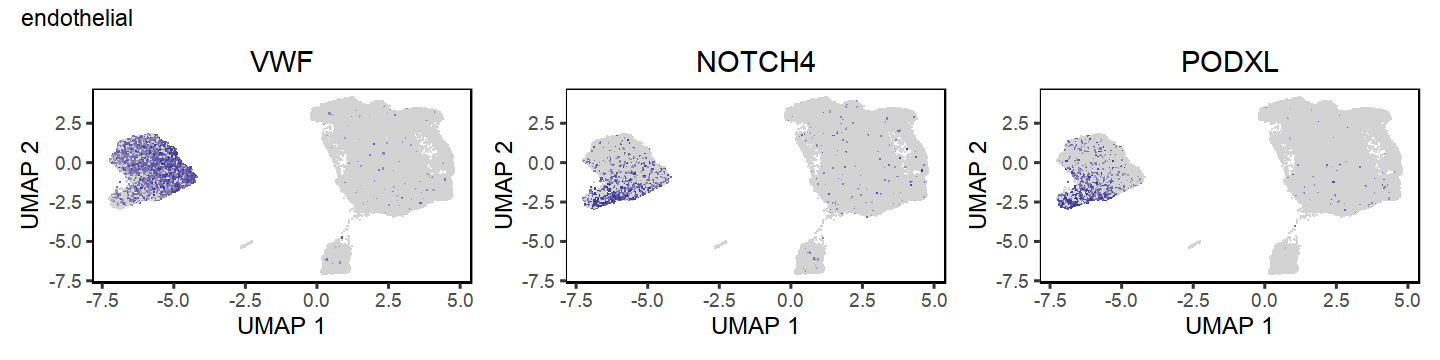

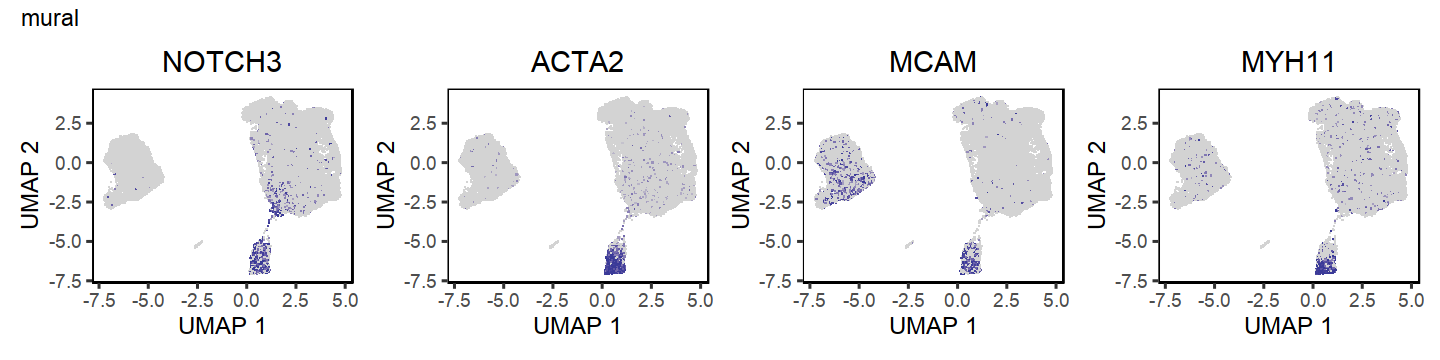

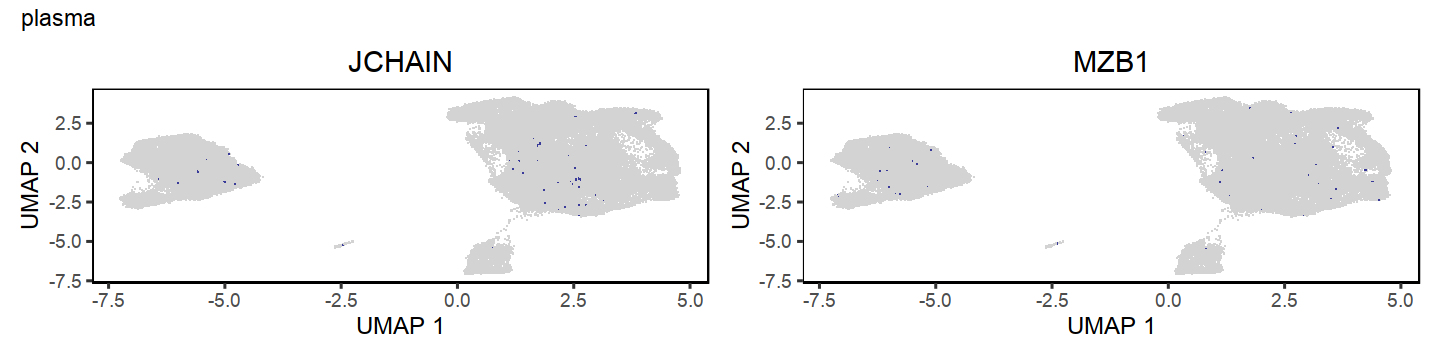

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


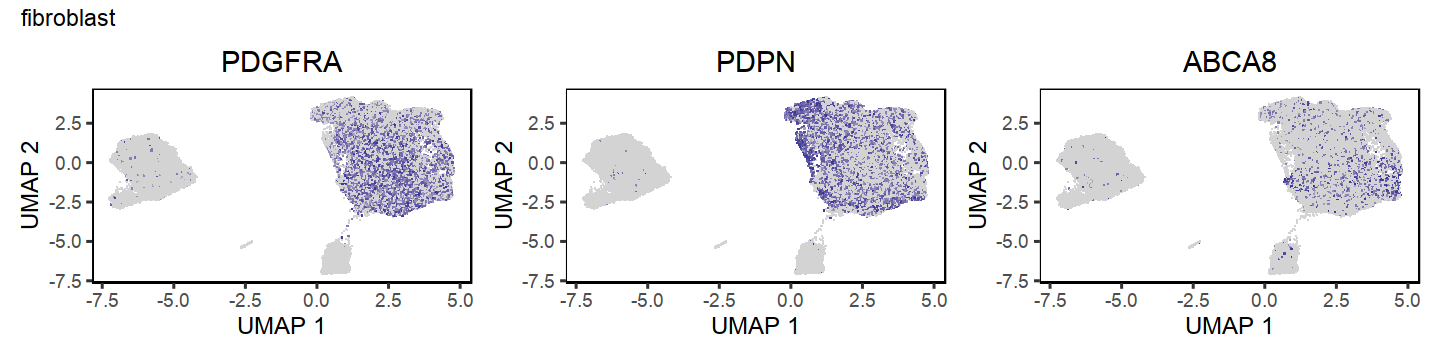

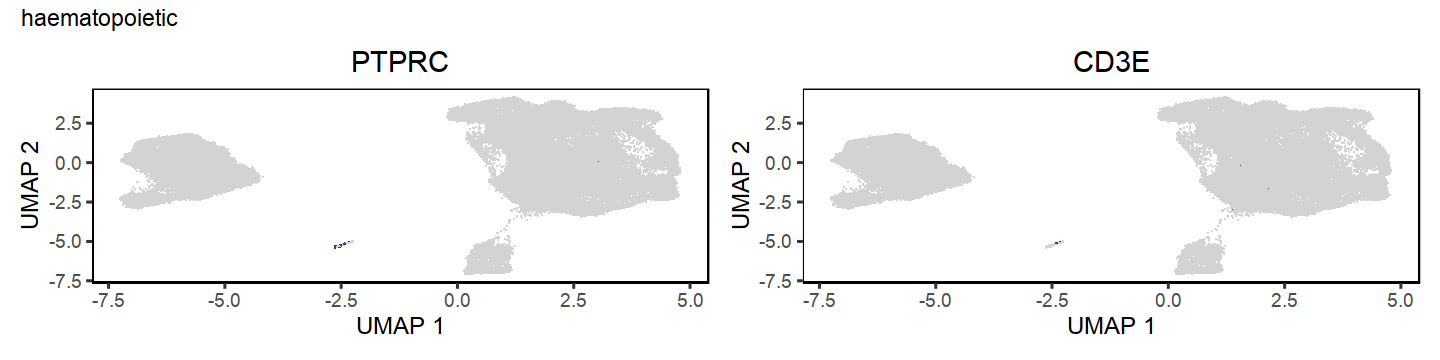

In [18]:
fig.size(3, 12)
with(obj, {
    lapply(names(lineage_markers), function(group) {
        plotFeatures(exprs_norm, umap_before,
                     intersect(lineage_markers[[group]], row.names(exprs_norm)), 
                     qhi = .99, no_guide = TRUE) + 
            plot_annotation(title = group)
    })    
})


Warning message:
“Ignoring unknown parameters: label.size”


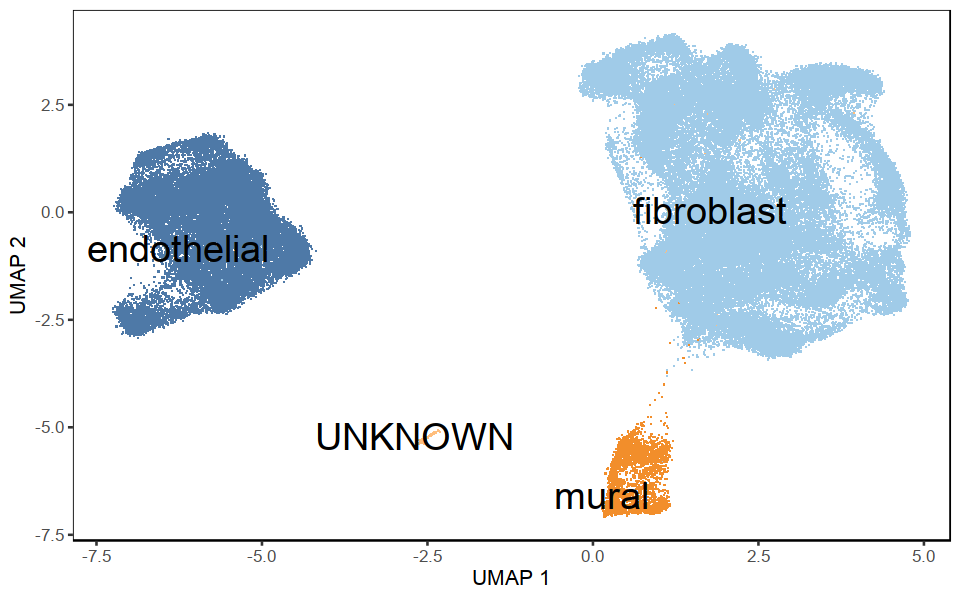

In [22]:
fig.size(5, 8)
do_scatter(obj$umap_before, obj$meta_data, 'lineage', pt_size = 8)


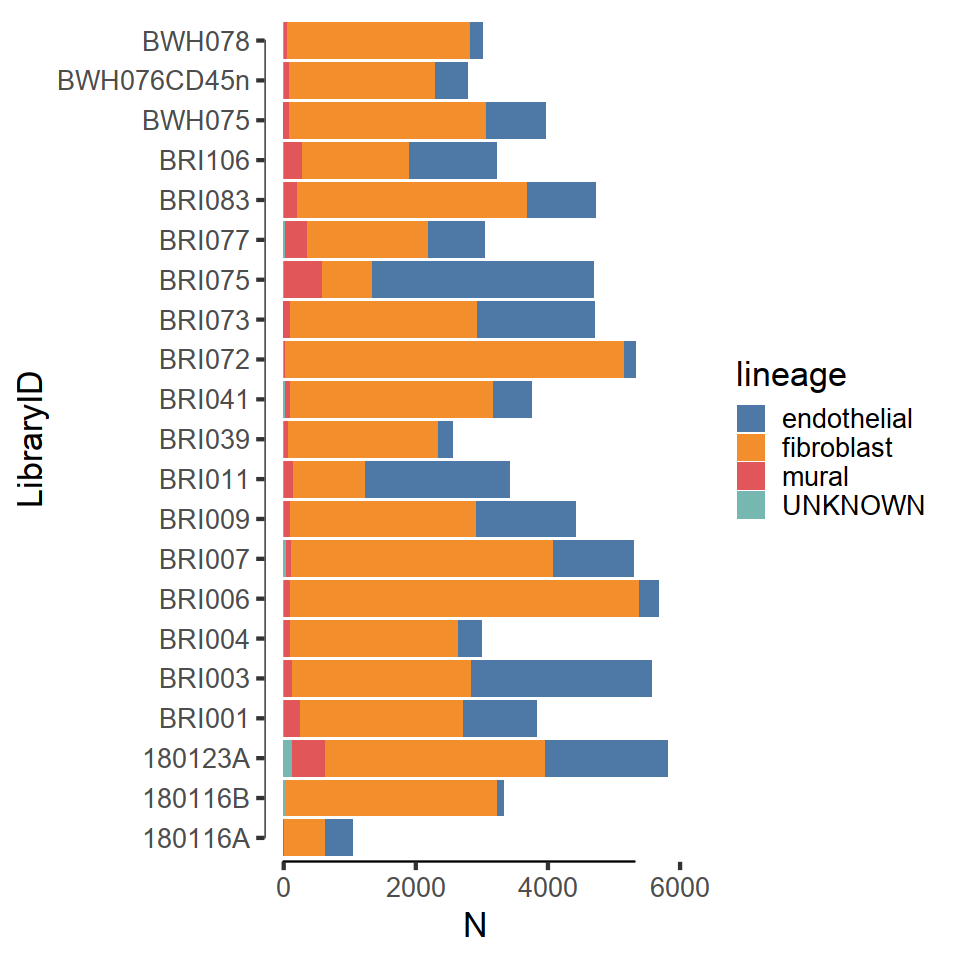

In [24]:
fig.size(8, 8)
data.table(obj$meta_data)[, .N, by = .(lineage, LibraryID)] %>% 
    ggplot(aes(LibraryID, N, fill = lineage)) + 
        geom_bar(stat = 'identity', position = position_stack()) + 
        theme_tufte(base_size = 20) + geom_rangeframe() + 
        scale_fill_tableau('Tableau 10') + 
        coord_flip() + 
        NULL

## Cache

In [25]:
saveRDS(obj, '/data/srlab/ik936/Roche/data/cache/synovium_obj_all.rds')

# Object 2: Stromal

In [11]:
obj <- readRDS('/data/srlab/ik936/Roche/data/cache/synovium_obj_all.rds')

## Create object

In [26]:
m <- obj$meta_data %>% subset(lineage %in% c('fibroblast', 'mural', 'endothelial', 'mesenchymal'))

# ## TESTING ONLY ##
# m <- m %>% subset(LibraryID %in% c('BRI003', 'BRI083'))
# ## TESTING ONLY ##

y <- factor(m$Case)
m$weight <- as.numeric((1 / prop.table(table(y)))[y]) / nlevels(y)
nrow(m)

[1] 82875

In [ ]:
fig.size(5, 8)
set.seed(1)
strom <- create_object(obj$exprs_raw[, m$CellID], m) %>% 
    do_harmony(
        'LibraryID', theta=.5, 
        max.iter.harmony=10, max.iter.cluster=20,
        epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
        weights = m$weight,
        plot_convergence = TRUE
    ) %>% 
    do_cluster(c(.1, .2, .3, .4))


start filter

start normalization

start vargenes

start pca

start UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 4143750)”
Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“invalid uid value replaced by that for user 'nobody'”


## Coarse types ("Lineage")

In [ ]:
fig.size(10, 16)
plot_clusters(strom, 'umap_after')

In [ ]:
strom$meta_data$lineage <- case_when(
    strom$clusters_df$res1 %in% c('2') ~ 'endothelial',
    strom$clusters_df$res1 %in% c('0', '1') ~ 'fibroblast',
    strom$clusters_df$res1 %in% c('3') ~ 'mural',
    TRUE ~ 'UNKNOWN'
)


In [ ]:
fig.size(5, 8)
do_scatter(strom$umap_after, strom$meta_data, 'lineage', pt_size = 8)


In [ ]:
# fig.size(3, 12)
# with(strom, {
#     lapply(names(lineage_markers), function(group) {
#         plotFeatures(exprs_norm, umap_after,
#                      intersect(lineage_markers[[group]], row.names(exprs_norm)), 
#                      qhi = .99, no_guide = TRUE) + 
#             plot_annotation(title = group)
#     })    
# })


## Cache

In [ ]:
saveRDS(strom, '/data/srlab/ik936/Roche/data/cache/synovium_obj_stromal.rds')

In [3]:
strom <- readRDS('/data/srlab/ik936/Roche/data/cache/synovium_obj_stromal.rds')

# Bulk

In [61]:
library(presto)
m <- obj$meta_data %>% 
    subset(!LibraryID %in% c('BWH008')) %>% 
#     subset(lineage == 'fibroblast') %>% 
    identity()
bulk <- presto::collapse_counts(obj$exprs_raw[, m$CellID], m, c('LibraryID', 'Case'))

## each Library has only one sample, so it's safe to call samples by LibraryID
colnames(bulk$counts_mat) <- bulk$meta_data$LibraryID
rownames(bulk$meta_data) <- bulk$meta_data$LibraryID


In [62]:
library(DESeq2)

genes_use <- rownames(bulk$counts_mat)[which(rowSums(bulk$counts_mat >= 3) >= 3)] %>% 
    setdiff(grep('^MT-', rownames(bulk$counts_mat), value=TRUE))


dds <- DESeqDataSetFromMatrix(
    countData = bulk$counts_mat[genes_use, ],
    colData = bulk$meta_data,
    design = ~1
)

vsd <- vst(dds, blind = FALSE)


converting counts to integer mode



In [63]:
colors_heat <- list(
    Case = tableau_color_pal('Tableau 10')(10)[1:2]
)
names(colors_heat$Case) <- unique(vsd$Case)
ann_df <- as.data.frame(vsd@colData)[, c('Case'), drop = FALSE]


In [64]:
# cormat <- cor(assay(vsd))
cormat <- assay(vsd) %>% t %>% scale %>% t %>% cor()

Based on the stromal profiles: 

- Outliers
    - BWH008 is a clear outlier (removed)
    - BRI015 is clear in the fibroblast only heatmap
- "Swaps"
    - The OA samples 180116A and BRI003 look more like RA than other OA samples
    - RA sample BRI072 looks more like OA samples than other RA samples
    - These can both be explained by the proportion of endothelial cells
- With fibroblasts only, 
    - BRI083 looks like OA: mostly lining FBs? 
    - 180116A and BRI003 still look RA! enriched in perivascular fibroblasts? 


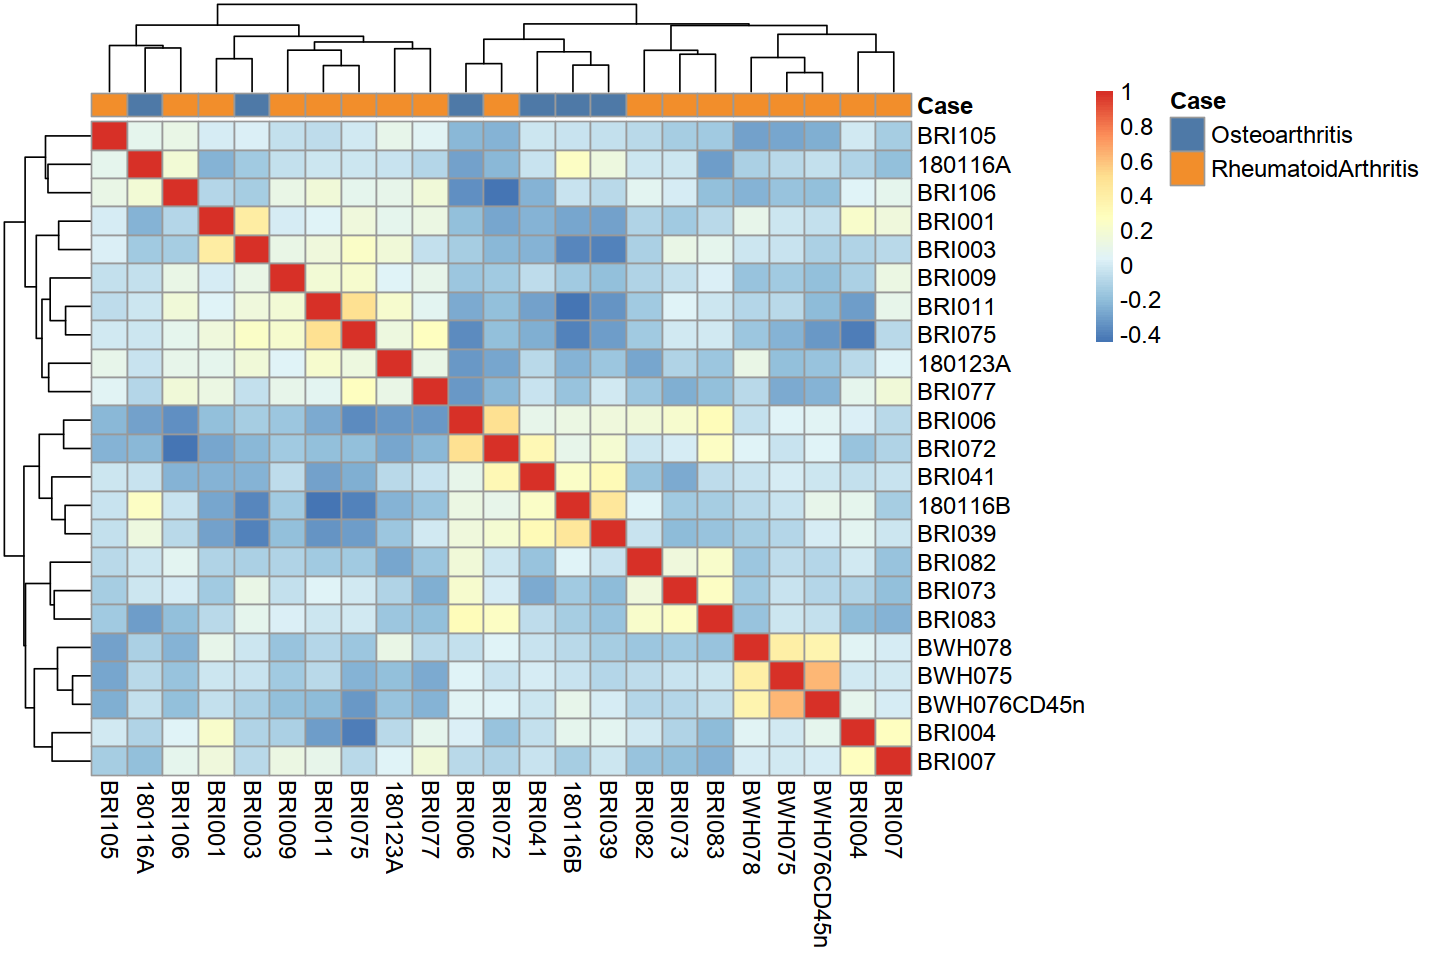

In [65]:
fig.size(8, 12)
pheatmap(fontsize=14,
    cormat, annotation = ann_df, annotation_colors = colors_heat, 
)

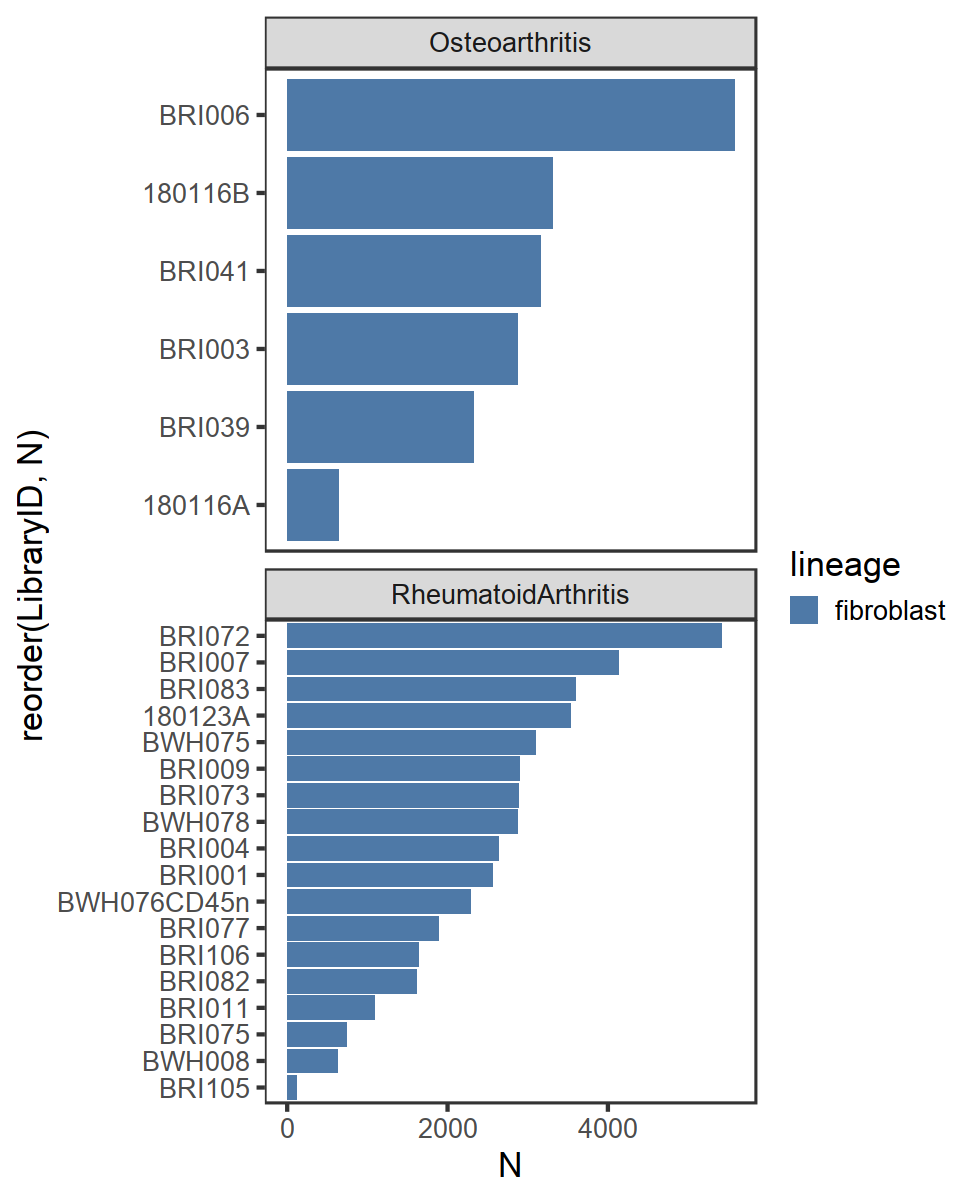

In [60]:
fig.size(10, 8)
data.table(obj$meta_data)[
    lineage %in% c('fibroblast')
    , .(U = sum(nUMI), N = .N)
    , by = .(LibraryID, lineage, Case)
] %>% 
    ggplot(aes(reorder(LibraryID, N), N, fill = lineage)) + 
#     ggplot(aes(reorder(LibraryID, U), U, fill = lineage)) + 
#         geom_bar(stat = 'identity', position = position_fill()) + 
        geom_bar(stat = 'identity') + 
        scale_fill_tableau() + 
#         scale_y_log10() + 
        theme_test(base_size = 20) + 
        coord_flip() + 
        facet_wrap(~Case, scales = 'free_y', ncol=1) + 
        NULL


# Compare to previous studies

In [197]:
obj <- readRDS('/data/srlab/ik936/Roche/data/cache/synovium_obj_stromal.rds')

## Subcluster fibroblasts

In [198]:
idx_fibro <- which(obj$meta_data$lineage == 'fibroblast')

In [202]:
fig.size(5, 8)
set.seed(1)
fib <- create_object(
    obj$exprs_raw[, idx_fibro], 
    obj$meta_data[idx_fibro, ] %>% dplyr::select(-weight),
    nvargenes = 2e4 ## keep all the genes
) 


start filter

Warning message in create_object(obj$exprs_raw[, idx_fibro], obj$meta_data[idx_fibro, :
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca

start UMAP

Warning message:
“invalid uid value replaced by that for user 'nobody'”


In [205]:
length(fib$var_genes)

[1] 16537

use_weights



[1] TRUE


use_weights

use_weights



[1] TRUE


use_weights

Harmony 1/5

Harmony 2/5

Harmony 3/5

Harmony 4/5

Harmony 5/5

Warning message:
“invalid uid value replaced by that for user 'nobody'”


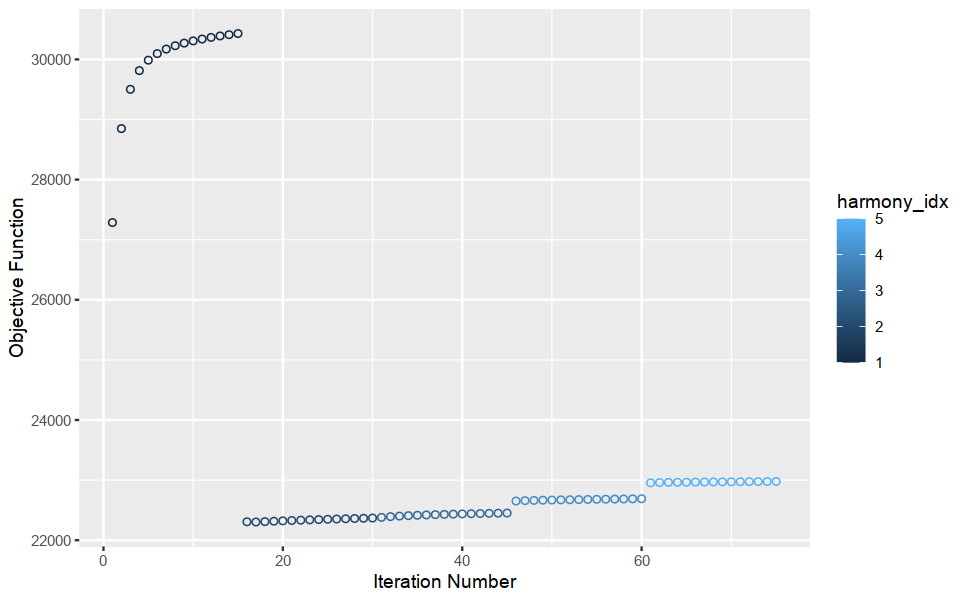

In [206]:
fib <- do_harmony(
    fib, 'LibraryID', theta=.5, 
    max.iter.harmony=5, max.iter.cluster=15,
    epsilon.cluster = -Inf, epsilon.harmony = -Inf, 
    weights = rep(1, nrow(fib$meta_data)), 
    plot_convergence = TRUE
)


In [43]:
# fig.size(3, 5)
# harmony:::HarmonyConvergencePlot(fib)


In [208]:
fib <- do_cluster(fib, 'adj_after', seq(0.1, 2.0, by = 0.2))


Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp

0.1

0.3

0.5

0.7

0.9

1.1

1.3

1.5

1.7

1.9

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3
* NA -> ...4
* NA -> ...5
* ...

finished Louvain



Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”
Warning message:
“Ignoring unknown parameters: segment.size”
W

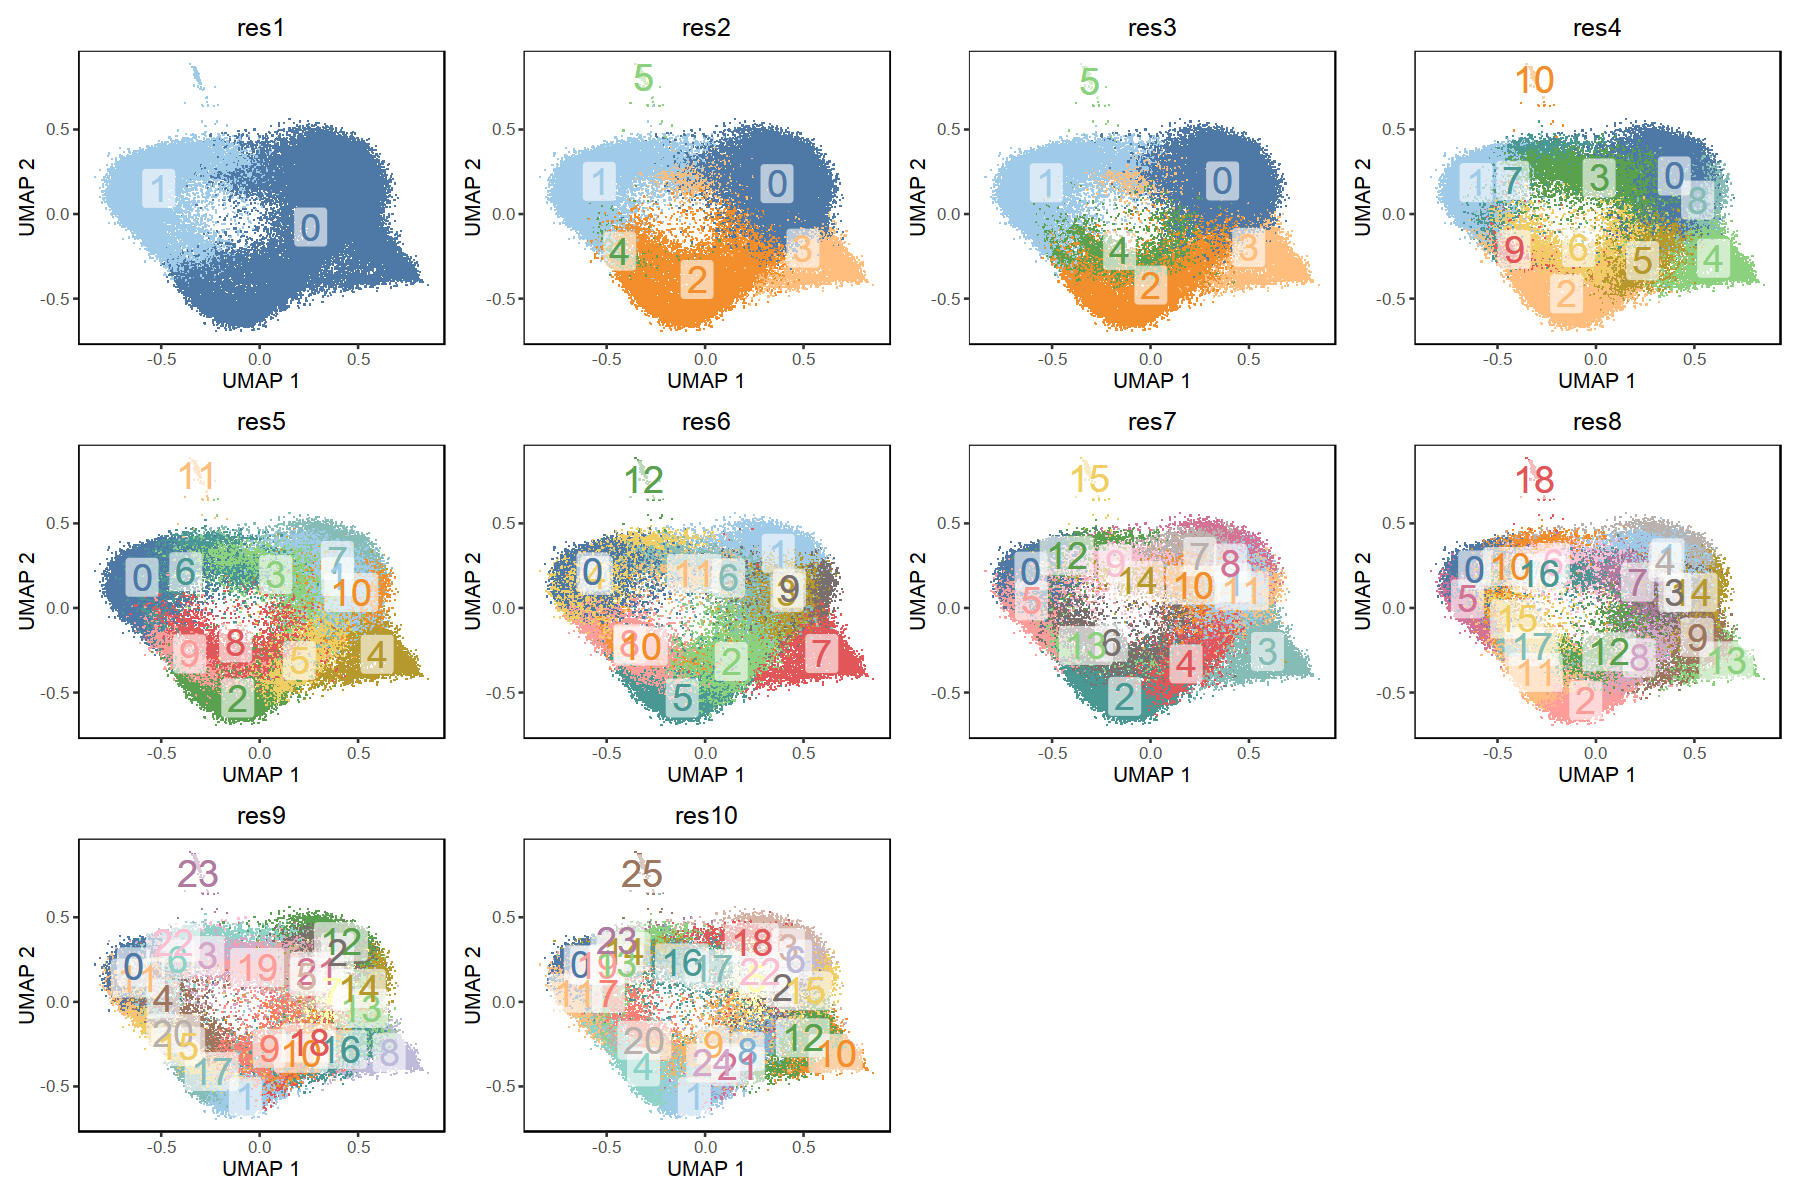

In [209]:
fig.size(10, 15)
# fig.size(6, 8)
plot_clusters(fib, 'umap_after')

In [90]:
# fig.size(6, 8)
# fib$meta_data %>% 
#     cbind(fib$clusters_df) %>% 
#     with(table(res5, DonorID)) %>% 
#     prop.table(2) %>% 
#     as('matrix') %>% 
# #     Heatmap()
#     head
# #     class


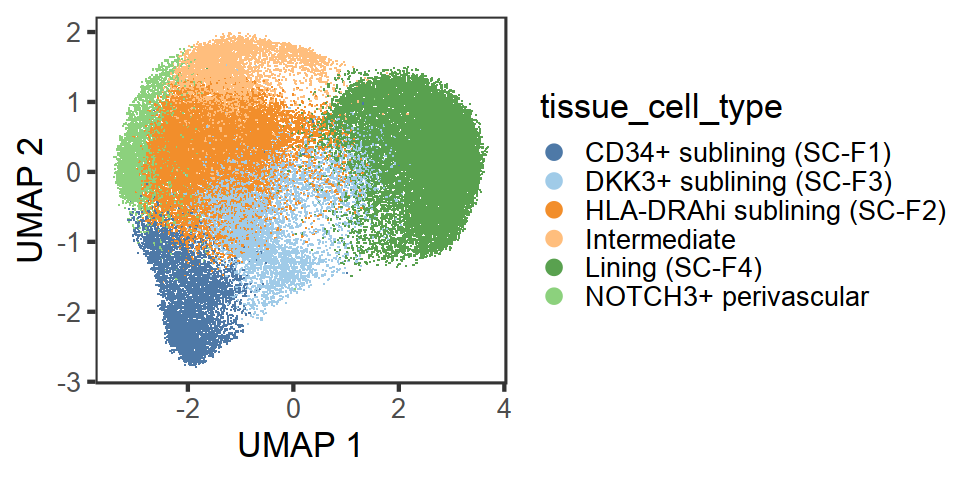

In [150]:
fig.size(4, 8)
idx <- which(!fib$meta_data$tissue_cell_type %in% c('UNKNOWN', 'LOWQC'))
do_scatter(fib$umap_after[idx, ], fib$meta_data[idx, ], 'tissue_cell_type', do_labels = FALSE, no_guides = FALSE) + 
    theme_test(base_size = 20)


## Compile marker genes 

- from AMP phase I paper


In [91]:
str <- 'DCN	CD74	ASPN	PRG4
IGF1	IFITM3	DKK3	FN1
FBLN1	LGALS3BP	MAMDC2	ITGB8
PDGFRL	HLA-DRA	ABHD2	CRTAC1
SFRP1	HLA-B	PRELP	HTRA1
C3	CXCL12	COL5A1	PCSK6
GAS6	HLA-DPA1	EMP1	HBEGF
FBLN5	HLA-DRB1	ANGPTL1	THBS4
RPL37	PLAU	CADM1	TIMP3
VCAN	HLA-A	FMOD	APLP2
RPL35A	IFI27	OGN	SMIM14
CD34	B2M	PDGFRB	NTN4
GSN	HLA-DPB1	CD109	CD55
SERPINF1	MDK	MYADM	CLIC5
PPAP2B	ZFP36L1	AHNAK	C10orf105
MFAP5	IFI30	VIM	ERRFI1
PODN	STAT1	COL8A2	CREB5
PTGFR	LOXL1	CAMK1D	BCAT1
SFRP2	BGN	DPT	FAM49A
CFH	C1S	COMP	ITGBL1
'


In [92]:
x <- strsplit(str, '\n') %>% map(strsplit, '\t') %>% map(data.frame)
x <- as.data.frame(t(x[[1]])) %>% as_tibble()
colnames(x) <- c('CD34+ sublining (SC-F1)', 'HLA-DRAhi sublining (SC-F2)', 'DKK3+ sublining (SC-F3)', 'Lining (SC-F4)')
gs_synovium <- x %>% as.list() %>% map(as.character)


In [93]:
bulk <- readRDS("/data/srlab/ik936/NOTCH/data/cache/bulk_data.rds")
with(bulk, {
    genes_dll4 <<- dge_dll4 %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) #%>% 
#         intersect(row.names(obj$exprs_norm))
    genes_jag1 <<- dge_jag1 %>% subset(adj.P.Val < .05 & logFC > 0) %>% with(symbol) #%>% 
#         intersect(row.names(obj$exprs_norm))

})
genes_notch <<- union(genes_dll4, genes_jag1)


In [94]:
gs_synovium$Notch <- genes_notch

## Presto

In [130]:
## Collapse Counts
pb <- presto::collapse_counts(
    fib$exprs_raw,
    cbind(fib$meta_data, Cluster = fib$clusters_df$res7), 
    c('Cluster', 'LibraryID'),
    keep_n=TRUE, 
    how='sum'
) 
pb$meta_data$logUMI <- log(colSums(pb$counts_mat))


In [131]:
dim(pb$meta_data)
dim(pb$meta_data)

[1] 356   4

[1] 356   4

In [132]:
# devtools::install_github('immunogenomics/')
devtools::load_all('/data/srlab/ik936/ReproducibleDGE/presto')

Loading presto



In [133]:
genes_test <- reduce(gs_synovium, union) %>% 
    union(c('THY1')) %>% 
    union(c('ACKR1', 'PTPRC', 'PECAM1', 'VWF', 'NOTCH4')) ## check for doublets
length(genes_test)


[1] 206

In [140]:
options(future.globals.maxSize = 1e9)

In [141]:
library(presto)
library(lme4)
library(future)
library(furrr)

## Fit Models
suppressWarnings({
    presto_obj <- presto.presto(
        formula = y~1+(1|Cluster)+(1|LibraryID/Cluster)+offset(logUMI), 
        design = pb$meta_data, 
        response = pb$counts_mat, 
        size_varname = 'logUMI',
        features = genes_test,
        ncore = 20,
        nsim = 1e3,
        effects_cov = c('Cluster'),
        min_sigma = .5,
        verbose = 1
    ) 
})


CAUTION: if using GLMM, make sure your counts are integers!

Set up models

Learn the models

Aggregate the results

Cleap up names

Joining, by = "grpvar_orig"

Compute gene means



In [142]:
contrasts_mat <- make_contrast.presto(presto_obj, 'Cluster')
effects <- contrasts.presto(presto_obj, contrasts_mat, one_tailed = TRUE) %>% 
    dplyr::mutate(Cluster = contrast) %>% 
    arrange(pvalue)


In [143]:
x <- gs_synovium %>% map(function(genes) {
    data.table(effects)[
        feature %in% genes, 
        mean(beta, na.rm = TRUE), 
#         mean(zscore, na.rm = TRUE), 
        by = Cluster
    ]
    
}) %>% 
    bind_rows(.id = 'CellType') %>% 
    tidyr::spread(Cluster, V1) %>% 
    tibble::column_to_rownames('CellType') %>% 
    as.matrix() %>% 
    identity()
    

In [144]:
# fig.size(5, 8)
# x %>% 
#     exp() %>% prop.table(2) %>% 
#     scale %>% 
#     Heatmap()


In [145]:
# effects %>% 
#     split(.$Cluster) %>% 
#     map(arrange, pvalue) %>% 
#     map(arrange, pvalue) %>% 
# #     map(arrange, -beta) %>% 
#     map(head, 5)


In [146]:
# effects %>% subset(feature == 'THY1') %>% 
#     arrange(pvalue)


In [147]:
# effects %>% 
#     subset(feature %in% c(
#         'PRG4', 'NOTCH3', 'DKK3', 'THY1', 'CD34', 'HLA-DRA', 'CD74', 'CCL19'
# #         'PTPRC', 'ACKR1', 'PECAM1', 'VWF', 'NOTCH4' ## doublet markers
#     )) %>% 
#     arrange(pvalue)


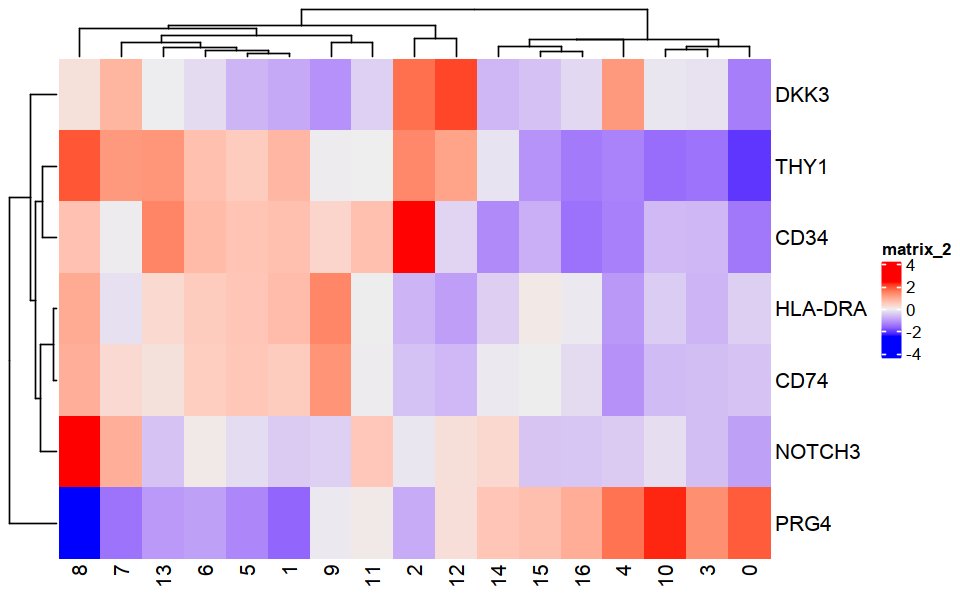

In [148]:
fig.size(5, 8)
effects %>% 
    subset(feature %in% c(
        'PRG4', 'NOTCH3', 'DKK3', 'THY1', 'CD34', 'HLA-DRA', 'CD74', 'CCL19'
#         'PTPRC', 'ACKR1', 'PECAM1', 'VWF', 'NOTCH4' ## doublet markers
    )) %>% 
    dplyr::select(feature, Cluster, beta) %>% 
    tidyr::spread(Cluster, beta) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() %>% 
    Heatmap()


In [149]:
effects %>% 
    arrange(pvalue) %>% 
    subset(feature %in% c('PTPRC', 'ACKR1', 'PECAM1', 'VWF', 'NOTCH4')) %>% 
    subset(pvalue < .05)
#     head()


contrast,feature,beta,sigma,zscore,pvalue,Cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
11,VWF,0.6143465,0.1897399,3.237836,0.000602201,11
8,PECAM1,0.4337294,0.1421993,3.050152,0.001143629,8
6,VWF,0.4805139,0.1699528,2.827337,0.002346845,6
6,PECAM1,0.3641990,0.1351231,2.695313,0.003516131,6
11,PECAM1,0.3931834,0.1602689,2.453274,0.007078132,11
6,ACKR1,0.3723995,0.1592500,2.338458,0.009681761,6
11,ACKR1,0.3532157,0.1777381,1.987282,0.023445598,11
2,NOTCH4,0.3045297,0.1649718,1.845950,0.032449719,2
11,NOTCH4,0.3079840,0.1784393,1.725987,0.042174856,11



## Label types 

Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


[[1]]


Warning message:
“Computation failed in `stat_summary_hex()`:
"hbin" not resolved from current namespace (hexbin)”


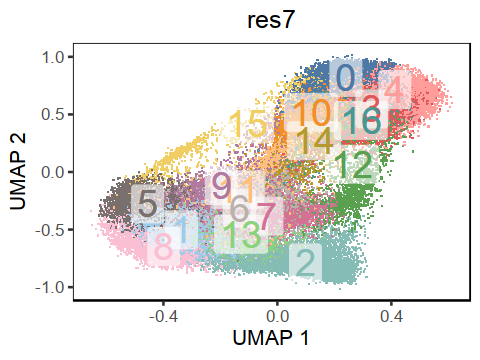

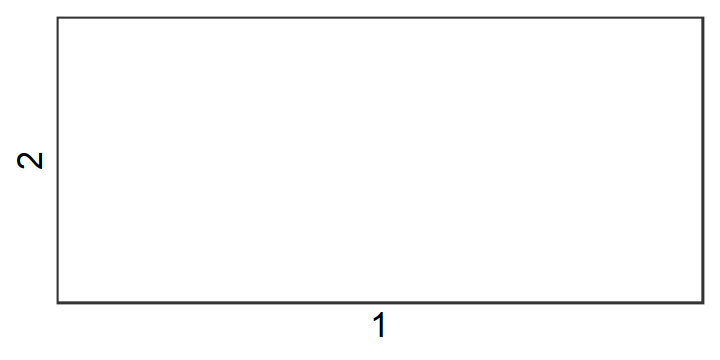

In [156]:
fig.size(3, 4)
plot_clusters(fib, 'umap_after', 'res7') 

fig.size(3, 6)
fib$meta_data %>% 
    cbind(fib$umap_after) %>% 
#     ggplot(aes(`1`, `2`, z = percent_mito)) + 
    ggplot(aes(`1`, `2`, z = scDblFinder.ratio)) + 
#         geom_point(shape = '.') + 
        stat_summary_hex(fun = mean, bins = 100) + 
#         geom_density_2d_filled() + 
        theme_test(base_size = 20) + 
        scale_fill_gradient2(midpoint = .3, low = 'white', mid = 'lightgrey') + 
#         scale_fill_gradient2_tableau() + 
#         facet_grid((scDblFinder.ratio < .2) ~ (percent_mito < 0.10)) + 
#         facet_wrap(~(scDblFinder.ratio < .2)) + 
        NULL



Picking joint bandwidth of 0.0324



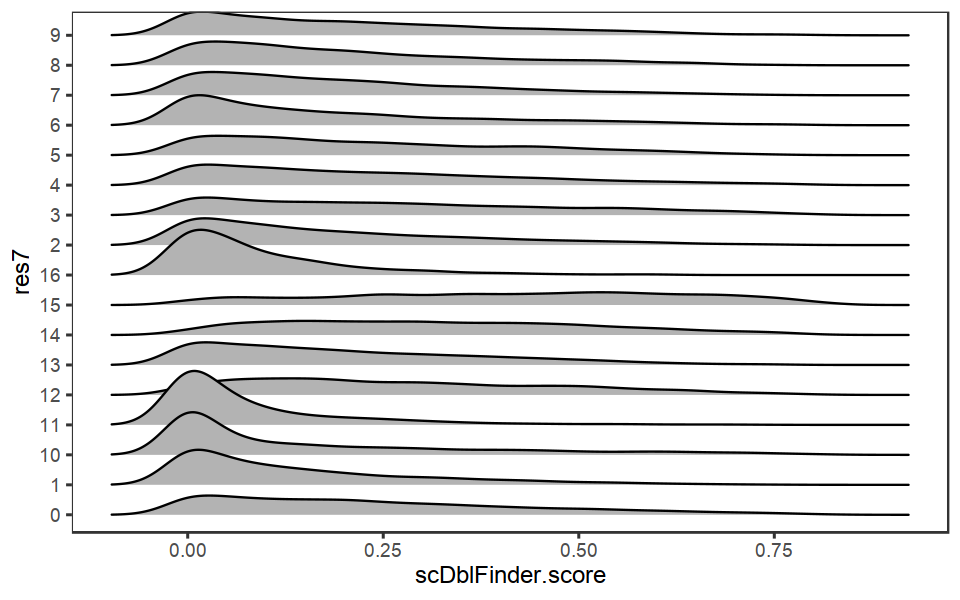

In [150]:
fib$meta_data %>% cbind(fib$clusters_df) %>% 
ggplot(aes(scDblFinder.score, res7)) + 
#         geom_violin() + 
    geom_density_ridges() + 
#         coord_flip() + 
    theme_test(base_size = 14) 


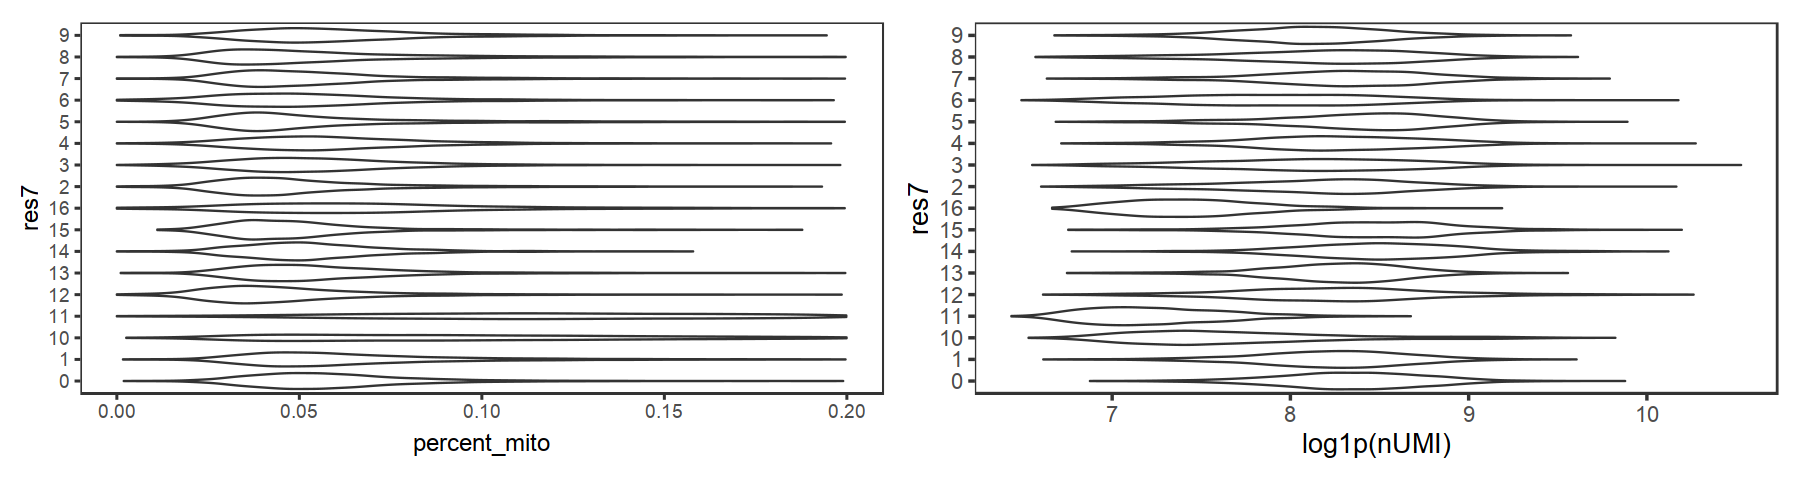

In [152]:
fig.size(4, 15)
fib$meta_data %>% cbind(fib$clusters_df) %>% 
ggplot(aes(res7, percent_mito)) + 
        geom_violin() + 
        coord_flip() + 
        theme_test(base_size = 14) + 

fib$meta_data %>% cbind(fib$clusters_df) %>% 
ggplot(aes(res7, log1p(nUMI))) + 
        geom_violin() + 
        coord_flip() + 
        theme_test(base_size = 16) + 

NULL


Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


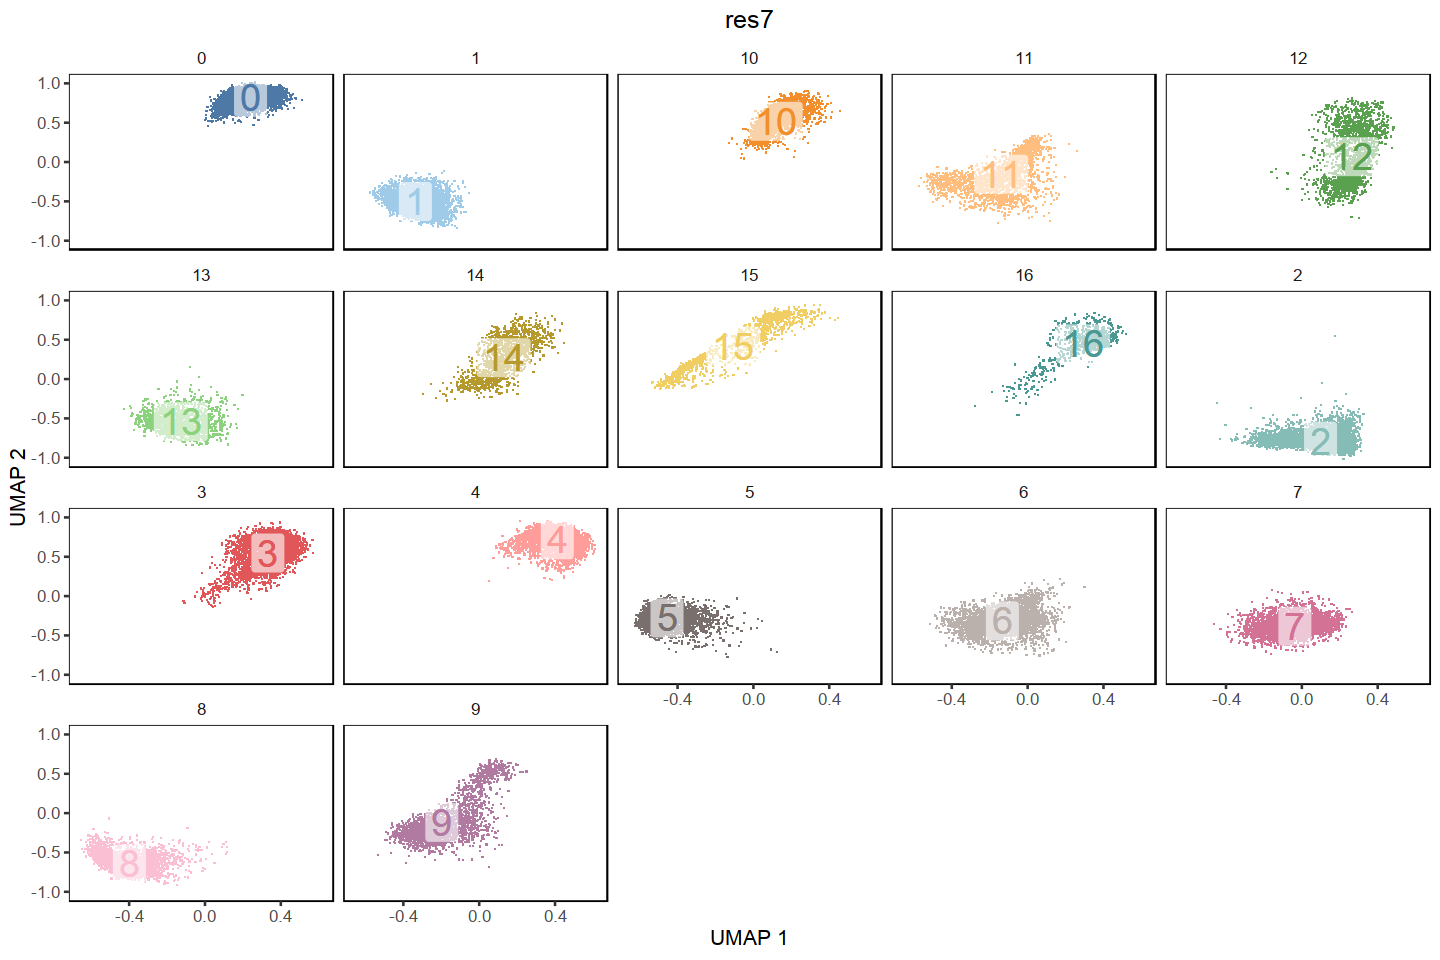

In [199]:
fig.size(8, 12)
# fig.size(3, 4)

plot_clusters(fib, 'umap_after', 'res7')[[1]] + facet_wrap(~res7)


In [180]:
fib$meta_data$tissue_cell_type <- case_when(
    fib$clusters_df$res2 %in% c('1') ~ 'Lining (SC-F4)',
    fib$clusters_df$res7 %in% c('10', '11') ~ 'LOWQC',
    fib$clusters_df$res7 %in% c('15') ~ 'DOUBLET',
    fib$clusters_df$res7 %in% c('9') ~ 'HLA-DRAhi sublining (SC-F2)',
    fib$clusters_df$res7 %in% c('2') ~ 'CD34+ sublining (SC-F1)',
    fib$clusters_df$res7 %in% c('12') ~ 'DKK3+ sublining (SC-F3)',
    fib$clusters_df$res2 %in% c('0', '2', '8') ~ 'Sublining',
    TRUE ~ 'UNKNOWN'
)



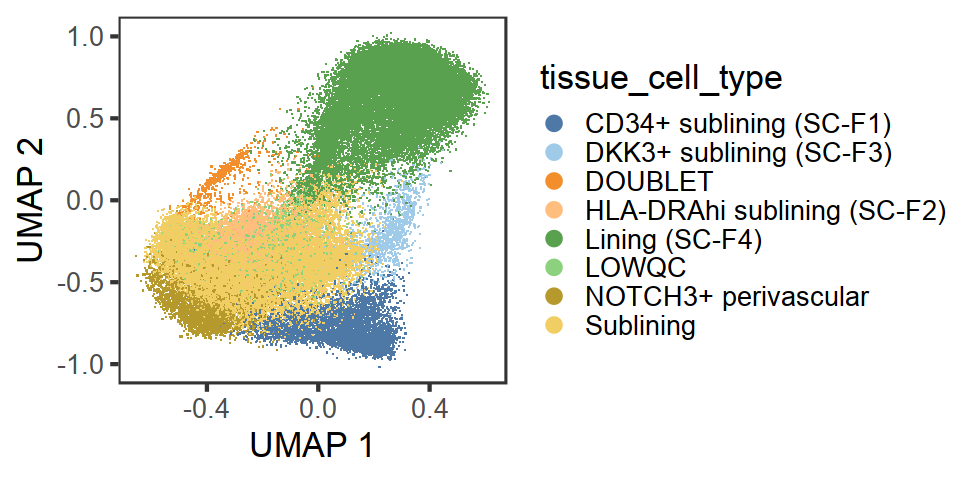

In [35]:
fig.size(4, 8)
# idx <- which(!fib$meta_data$tissue_cell_type %in% c('UNKNOWN', 'LOWQC'))
# idx <- which(!fib$meta_data$tissue_cell_type %in% c('LOWQC'))
idx <- seq(nrow(fib$meta_data))
# idx <- which(!fib$meta_data$tissue_cell_type %in% c('DOUBLET', 'LOWQC'))
# idx <- which(fib$meta_data$tissue_cell_type %in% c('UNKNOWN', 'LOWQC'))
do_scatter(fib$umap_after[idx, ], fib$meta_data[idx, ], 'tissue_cell_type', do_labels = FALSE, no_guides = FALSE) + 
    theme_test(base_size = 20) 

# + 
#     facet_wrap(~tissue_cell_type %in% c('DOUBLET'))


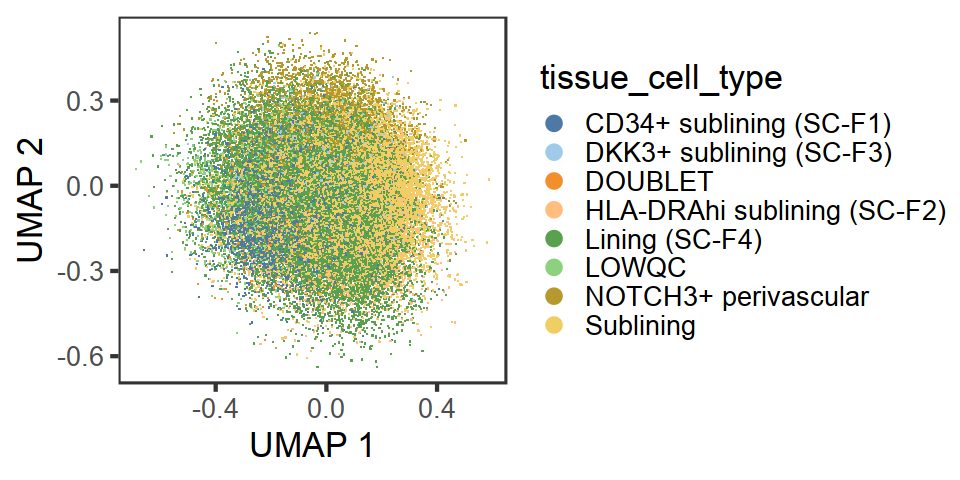

In [41]:
fig.size(4, 8)
# idx <- which(!fib$meta_data$tissue_cell_type %in% c('UNKNOWN', 'LOWQC'))
# idx <- which(!fib$meta_data$tissue_cell_type %in% c('LOWQC'))
idx <- seq(nrow(fib$meta_data))
# idx <- which(!fib$meta_data$tissue_cell_type %in% c('DOUBLET', 'LOWQC'))
# idx <- which(fib$meta_data$tissue_cell_type %in% c('UNKNOWN', 'LOWQC'))
do_scatter(t(fib$Z_cos)[idx, c(9, 10)], fib$meta_data[idx, ], 'tissue_cell_type', do_labels = FALSE, no_guides = FALSE) + 
    theme_test(base_size = 20) 

# + 
#     facet_wrap(~tissue_cell_type %in% c('DOUBLET'))


In [37]:
dim(fib$Z_cos)

[1]    30 57185

## Redo Presto on labels

In [252]:
devtools::load_all('/data/srlab/ik936/ReproducibleDGE/presto')

Loading presto


Attaching package: ‘testthat’


The following objects are masked from ‘package:magrittr’:

    equals, is_less_than, not


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches




In [248]:
## Collapse Counts
idx <- which(!fib$meta_data$tissue_cell_type %in% c('UNKNOWN', 'LOWQC', 'DOUBLET'))

pb <- presto::collapse_counts(
    fib$exprs_raw[, idx],
#     cbind(fib$meta_data, Cluster = fib$clusters_df$res4), 
    fib$meta_data[idx, ] %>% dplyr::rename(Cluster = tissue_cell_type), 
    c('Cluster', 'LibraryID'),
    keep_n=TRUE, 
    how='sum'
) 
pb$meta_data$logUMI <- log(colSums(pb$counts_mat))



In [253]:
# library(presto)
library(lme4)
library(future)
library(furrr)

In [254]:
genes_test <- rownames(pb$counts_mat)[which(rowSums(pb$counts_mat >= 5) >= 10)]
length(genes_test)

## Fit Models
suppressWarnings({
    presto_obj <- presto.presto(
        formula = y~1+(1|Cluster)+(1|LibraryID/Cluster)+offset(logUMI), 
        design = pb$meta_data, 
        response = pb$counts_mat, 
        size_varname = 'logUMI',
        features = genes_test,
        ncore = 20,
        nsim = 1e3,
        effects_cov = c('Cluster'),
        min_sigma = .5 * log(2),
        verbose = 1
    ) 
})


[1] 14189

CAUTION: if using GLMM, make sure your counts are integers!

Set up models

Learn the models

Aggregate the results

Cleap up names

Joining, by = "grpvar_orig"

Compute gene means



In [258]:
reduce <- purrr::reduce

In [259]:
contrasts_mat <- make_contrast.presto(presto_obj, 'Cluster')
presto_obj$effects <- contrasts.presto(presto_obj, contrasts_mat, one_tailed = TRUE) %>% 
    dplyr::mutate(Cluster = contrast) %>% 
    arrange(pvalue)


In [260]:
unique(presto_obj$effects$Cluster)

[1] "Lining (SC-F4)"              "NOTCH3+ perivascular"       
[3] "CD34+ sublining (SC-F1)"     "DKK3+ sublining (SC-F3)"    
[5] "HLA-DRAhi sublining (SC-F2)" "Sublining"

In [261]:
## Now that we've removed doublets, did we remove this weird endothelial signal? 
presto_obj$effects %>% 
    subset(feature %in% c('ACKR1', 'PECAM1', 'VWF', 'NOTCH4')) %>% 
    arrange(pvalue) %>% 
    subset(pvalue < .05) %>% 
    head(10)


contrast,feature,beta,sigma,zscore,pvalue,Cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
NOTCH3+ perivascular,PECAM1,0.3850357,0.0982845,3.917563,4.472437e-05,NOTCH3+ perivascular
CD34+ sublining (SC-F1),NOTCH4,0.2849020,0.1304401,2.184159,1.447529e-02,CD34+ sublining (SC-F1)
NOTCH3+ perivascular,NOTCH4,0.2230513,0.1080618,2.064109,1.950371e-02,NOTCH3+ perivascular
HLA-DRAhi sublining (SC-F2),VWF,0.2709954,0.1395952,1.941294,2.611131e-02,HLA-DRAhi sublining (SC-F2)


In [262]:
presto_obj$effects %>% 
    split(.$Cluster) %>% 
    map(arrange, pvalue) %>% 
    map(head, 5)

contrast,feature,beta,sigma,zscore,pvalue,Cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CD34+ sublining (SC-F1),PI16,6.633307,0.32430179,20.45412,2.760549e-93,CD34+ sublining (SC-F1)
CD34+ sublining (SC-F1),CD34,2.121173,0.10524665,20.15430,1.233574e-90,CD34+ sublining (SC-F1)
CD34+ sublining (SC-F1),MFAP5,3.556068,0.18078116,19.67057,1.927156e-86,CD34+ sublining (SC-F1)
CD34+ sublining (SC-F1),NHSL1,3.060371,0.16418446,18.63984,7.635529e-78,CD34+ sublining (SC-F1)
CD34+ sublining (SC-F1),ITGA11,1.719024,0.09963434,17.25333,5.281378e-67,CD34+ sublining (SC-F1)
contrast,feature,beta,sigma,zscore,pvalue,Cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
DKK3+ sublining (SC-F3),CAPG,1.659935,0.11532965,14.39296,2.864622e-47,DKK3+ sublining (SC-F3)
DKK3+ sublining (SC-F3),RGCC,1.506056,0.11392506,13.21971,3.376189e-40,DKK3+ sublining (SC-F3)


## Cache

In [263]:
fib$presto <- presto_obj
# fib$gs <- gs_synovium

In [264]:
saveRDS(fib, '/data/srlab/ik936/Roche/data/cache/synovium_fibroblasts_obj.rds')

# Inflammation association

In [236]:
fib <- readRDS('/data/srlab/ik936/Roche/data/cache/synovium_fibroblasts_obj.rds')

## Doublet scores

In [51]:
# hist(fib$meta_data$percent_mito)

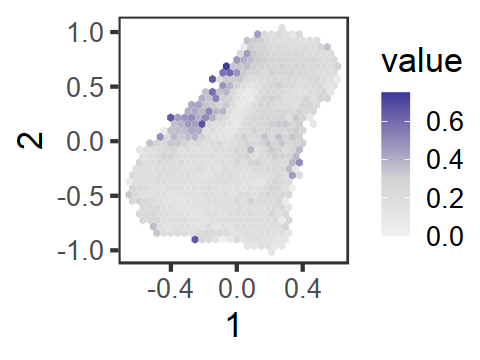

In [32]:
fig.size(3, 4)
fib$meta_data %>% 
    cbind(fib$umap_after) %>%
#     ggplot(aes(`1`, `2`, z = percent_mito)) + 
    ggplot(aes(`1`, `2`, z = scDblFinder.ratio)) + 
#         geom_point(shape = '.') + 
        stat_summary_hex(fun = mean, bins = 30) + 
#         geom_density_2d_filled() + 
        theme_test(base_size = 20) + 
        scale_fill_gradient2(midpoint = .3, low = 'white', mid = 'lightgrey') + 
#         scale_fill_gradient2_tableau() + 
#         facet_grid((scDblFinder.ratio < .2) ~ (percent_mito < 0.10)) + 
#         facet_wrap(~(scDblFinder.ratio < .2)) + 
        NULL



In [4]:
# fig.size(3, 5)
# plot_clusters(fib, 'umap_after', 'res4')


## Hex

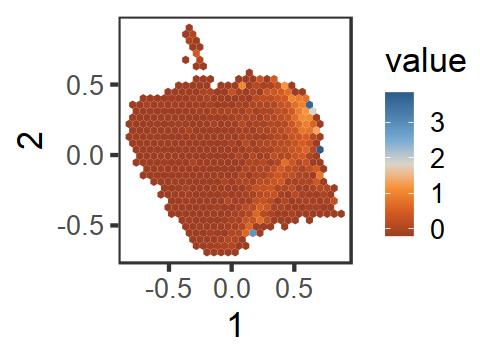

In [235]:
fig.size(3, 4)
fib$meta_data %>% 
    cbind(fib$umap_after) %>%
    cbind(Value = scale(fib$exprs_norm['IL6', ])) %>% 
#     subset(!tissue_cell_type %in% c('DOUBLET', 'LOWQC')) %>% 
#     ggplot(aes(`1`, `2`, z = percent_mito)) + 
    ggplot(aes(`1`, `2`, z = Value)) + 
#         geom_point(shape = '.') + 
        stat_summary_hex(fun = mean, bins = 30) + 
#         geom_density_2d_filled() + 
        theme_test(base_size = 20) + 
#         scale_fill_gradient2(midpoint = 2, low = 'white', mid = 'lightgrey') + 
        scale_fill_gradient2_tableau() + 
#         facet_grid((scDblFinder.ratio < .2) ~ (percent_mito < 0.10)) + 
#         facet_wrap(~(scDblFinder.ratio < .2)) + 
        NULL



## Cluster markers

In [6]:
devtools::load_all('/data/srlab/ik936/ReproducibleDGE/presto')

Loading presto



In [7]:
head(fib$meta_data)

CellID,LibraryID,nGene,nUMI,percent_mito,SampleID,Technology,Tissue,DonorID,Case,Diagnosis,scDblFinder.weighted,scDblFinder.ratio,scDblFinder.score,scDblFinder.class,lineage,weight,tissue_cell_type
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
AAACGGGTCACGCGGT_180116A,180116A,930,3551,0.07687975,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.09969786,0.10,0.09969786,singlet,fibroblast,1,LOWQC
AAAGATGAGTGAAGAG_180116A,180116A,529,1269,0.05516154,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.00000000,0.00,0.00000000,singlet,fibroblast,1,Lining (SC-F4)
AAAGTAGAGTGCAAGC_180116A,180116A,1462,3301,0.08966980,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.14642697,0.15,0.14642697,singlet,fibroblast,1,Lining (SC-F4)
AAAGTAGCATCTCCCA_180116A,180116A,1398,4668,0.08526135,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.26175574,0.25,0.26175574,singlet,fibroblast,1,CD34+ sublining (SC-F1)
AAAGTAGTCCTCAATT_180116A,180116A,1786,6771,0.11327721,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.23514752,0.20,0.23514752,singlet,fibroblast,1,Lining (SC-F4)
AAATGCCGTAGGGACT_180116A,180116A,523,1388,0.02521614,OA180104_A,10XV2,Synovium,OA180104_A,Osteoarthritis,NA,0.00000000,0.00,0.00000000,singlet,fibroblast,1,LOWQC


In [8]:
unique(fib$meta_data$Case)

[1] "Osteoarthritis"      "RheumatoidArthritis"

In [9]:
## Collapse Counts
pb <- presto::collapse_counts(
    fib$exprs_raw,
    cbind(
        fib$meta_data,
#         dplyr::select(fib$meta_data, -Cluster), 
        Cluster = fib$clusters_df$res4
    ), 
    c('Cluster', 'LibraryID', 'Case', 'DonorID'),
    keep_n=TRUE, 
    how='sum'
) 
pb$meta_data$logUMI <- log(colSums(pb$counts_mat))


In [10]:
# genes_test <- rownames(pb$counts_mat)[which(rowSums(pb$counts_mat >= 2) >= 5)]
genes_test <- c(
    'IL7R', 'CXCL9', 'CXCL10', 'HLA-DRA', 'HLA-DQB1', 'CD74', 'MAFF', 'IL6', 
    'CCL2', 'CCL19',
    'NOTCH3', 'SPARC', 'POSTN', 'COL3A1', 'FBN1', 'FBN2', 'CD34', 'PRG4', 'CD55',
    'VWF', 'PECAM1', 'NOTCH4', 'PODXL', 'ACKR1', 'MYH11', 'MYL9', 'MCAM', 'PDGFRB'
)
length(genes_test)

[1] 28

In [11]:
library(presto)
library(lme4)
library(future)
library(furrr)

In [12]:
## Fit Models
suppressWarnings({
    system.time({
        presto_obj <- presto.presto(
            formula = y~1+(1|Cluster)+(1|LibraryID/Cluster)+logUMI, 
            design = pb$meta_data, 
            response = pb$counts_mat, 
            features = genes_test, 
            size_varname = 'logUMI',
            ncore = 20,
            nsim = 1e3,
            effects_cov = c('Cluster'),
            min_sigma = .5 * log(2),
            verbose = 1
        ) 
    })
})


contrasts_mat <- make_contrast.presto(presto_obj, 'Cluster')
presto_obj$effects <- contrasts.presto(presto_obj, contrasts_mat, one_tailed = TRUE) %>% 
    dplyr::mutate(Cluster = contrast) %>% 
    arrange(pvalue)


CAUTION: if using GLMM, make sure your counts are integers!

Set up models

Learn the models

Aggregate the results

Cleap up names

Joining, by = "grpvar_orig"

Compute gene means



   user  system elapsed 
 37.320  25.338   4.758 

In [26]:
presto_obj$effects %>% 
    subset(pvalue < .05) %>% 
    split(.$Cluster) %>% 
    map(arrange, pvalue)

contrast,feature,beta,sigma,zscore,pvalue,Cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,PRG4,2.2262014,0.1286823,17.299978,2.352834e-67,0
0,CD55,1.1519009,0.1047783,10.993695,2.048995e-28,0
0,HLA-DQB1,0.3171164,0.1343503,2.360369,9.128380e-03,0
0,ACKR1,0.2768818,0.1193263,2.320375,1.016031e-02,0
0,VWF,0.2762867,0.1304690,2.117642,1.710269e-02,0
0,MCAM,0.2474260,0.1371862,1.803578,3.564873e-02,0
contrast,feature,beta,sigma,zscore,pvalue,Cluster
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,CD74,0.9946675,0.09924727,10.022115,6.093323e-24,1


In [24]:
# presto_obj$effects %>% 
#     subset(pvalue < .05) %>% 
#     split(.$feature) %>% 
#     map(arrange, pvalue)

In [244]:
# presto_obj$effects %>% 
#     subset(pvalue < .05) %>% 
#     split(.$feature) %>% 
#     map(arrange, pvalue)


## MASC

In [14]:
presto_obj$meta_data %>% head

,Cluster,LibraryID,Case,DonorID,N,logUMI,EXPOSURE
,<fct>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,5,180116A,Osteoarthritis,OA180104_A,110,12.41517,12.41517
2,0,180116A,Osteoarthritis,OA180104_A,309,14.19344,14.19344
3,3,180116A,Osteoarthritis,OA180104_A,84,12.84374,12.84374
4,2,180116A,Osteoarthritis,OA180104_A,41,12.41147,12.41147
5,4,180116A,Osteoarthritis,OA180104_A,11,10.62980,10.62980
6,1,180116A,Osteoarthritis,OA180104_A,73,12.81782,12.81782


In [15]:
set.seed(2)
inflam_scores_df <- readRDS('/data/srlab/ik936/Roche/data/cache/inflam_scores_icdf.rds')
data_df <- pb$meta_data %>% 
    dplyr::left_join(inflam_scores_df) %>% 
#     subset(!Case %in% c('GutControl')) %>% 
#     subset(!Case %in% c('GutNonisnflamed')) %>% 
    identity()


Joining, by = "LibraryID"



In [16]:
masc_res <- unique(data_df$Cluster) %>% map(function(cluster_test) {
    data_use <- data_df %>% 
        dplyr::mutate(Response = case_when(
            Cluster == cluster_test ~ 1L,
            TRUE ~ 0L 
        ))
    
    glmod <- glFormula(
#         Response ~ 1 + InflamScore_beta + (1|LibraryID),
        Response ~ 1 + InflamScore_beta + (1|LibraryID) + (1|Case),
        data_use, 
        family = 'binomial',
        weights = N
    )
    
    ## Learn model with minimum sigma, for numerical stability 
    devfun <- do.call(mkGlmerDevfun, glmod)
    environment(devfun)$lower <- rep(.1, length(environment(devfun)$lower))
    opt <- optimizeGlmer(devfun, stage = 1)
    devfun <- updateGlmerDevfun(devfun, glmod$reTrms)
    opt <- optimizeGlmer(devfun, stage=2)
    model <- mkMerMod(environment(devfun), opt, glmod$reTrms, fr = glmod$fr)
    
    tibble(
        Cluster = cluster_test,
        beta = fixef(model)[['InflamScore_beta']] / log(2),
        sigma = sqrt(vcov(model)['InflamScore_beta', 'InflamScore_beta']) / log(2),
        pvalue = 2 * (1 - pnorm(abs(beta / sigma)))
    )
}) %>% 
    bind_rows() %>% 
    arrange(-beta/sigma)


In [17]:
masc_res

Cluster,beta,sigma,pvalue
<fct>,<dbl>,<dbl>,<dbl>
6,4.8135646,0.5374926,0.000000e+00
4,2.3744679,0.3826147,5.438543e-10
1,2.0120948,0.4405617,4.944879e-06
2,1.3364598,0.3715969,3.224886e-04
3,0.5370535,0.8545276,5.296895e-01
5,-1.8605648,0.4562471,4.542938e-05
0,-4.6475682,0.5456907,0.000000e+00


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



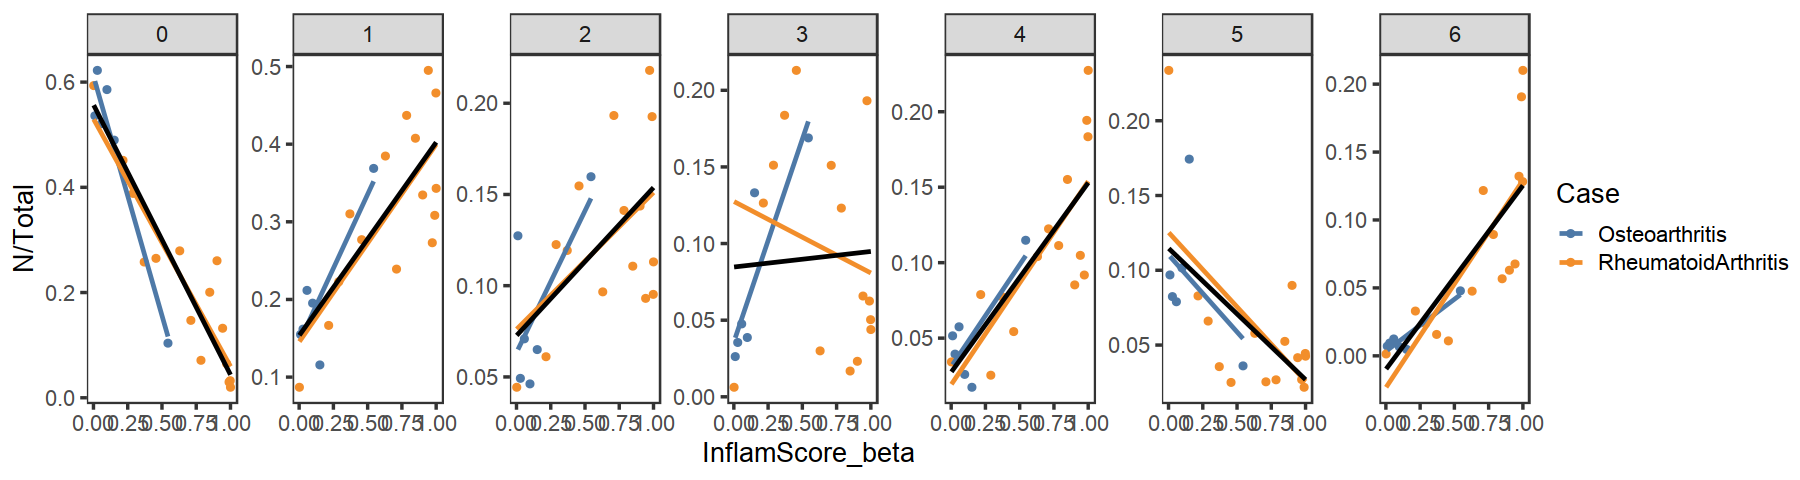

In [25]:
fig.size(4, 15)
plt <- data.table(data_df)[, Total := sum(N), by = LibraryID][] %>% 
    ggplot(aes(InflamScore_beta, N / Total)) + 
        facet_wrap(~Cluster, scales = 'free', nrow = 1) + 
        scale_color_tableau() + 
        theme_test(base_size = 16)

plt + 
    geom_point(aes(color = Case)) + 
    geom_smooth(method = 'lm', se = FALSE, aes(color = Case)) + 
    geom_smooth(method = 'lm', se = FALSE, color = 'black') + 
#     guides(color = FALSE) + 
    NULL
